In [1]:
from utils import *
df = load_dataframe(path="../data/final_data_30_shards")
df = df.fillna(0.0)
print(df.shape)
print(df.columns)

(683254, 75)
Index(['Result', 'WhiteElo', 'BlackElo', 'ECO', 'Opening', 'Termination',
       'parsed_num_moves', 'white_accuracy_cp', 'black_accuracy_cp',
       'ECO_white_accuracy_cp_mean', 'ECO_white_accuracy_cp_median',
       'ECO_white_accuracy_cp_std', 'ECO_black_accuracy_cp_mean',
       'ECO_black_accuracy_cp_median', 'ECO_black_accuracy_cp_std',
       'White_white_accuracy_cp_mean', 'White_white_accuracy_cp_median',
       'White_white_accuracy_cp_std', 'White_black_accuracy_cp_mean',
       'White_black_accuracy_cp_median', 'White_black_accuracy_cp_std',
       'total_full_moves', 'moves_before_castle_white',
       'moves_before_castle_black', 'legal_move_diff_at_25',
       'legal_move_diff_at_50', 'legal_move_diff_at_75',
       'legal_move_diff_at_100', 'development_before_white',
       'development_before_black', 'center_control_after_5_white',
       'unique_pieces_after_10_white', 'unique_pieces_after_10_black',
       'blunder_counts_white', 'blunder_counts_black'

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

y_reg_white = df['WhiteElo']
y_reg_black = df['BlackElo']
y_reg_avg = df[['WhiteElo', 'BlackElo']].mean(axis=1)
y_clf_avg = pd.qcut(y_reg_avg, q=10, labels=False, duplicates='drop')

# Define the feature matrix (X) by dropping target variables and non-feature columns
categorical = df[['Termination', "ECO"]]
X = df.drop(columns=['WhiteElo', 'BlackElo', 'Result', 'Opening', 'Termination', "ECO"])

X_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns, index=X.index)

# 2) One‑hot encode your categorical subset correctly:
categorical_OHE = pd.get_dummies(
    categorical,
    columns=['ECO', 'Termination'],
    drop_first=False
)
X_final = X_scaled.join(categorical_OHE)


X_train, X_test, y_train_clf, y_test_clf = train_test_split(X_final, y_clf_avg, test_size=0.3, random_state=42)

RandomForest Classification Accuracy: 0.24812539943505857
Classification Report:               precision    recall  f1-score   support

           0       0.37      0.69      0.48     20568
           1       0.19      0.21      0.20     20572
           2       0.16      0.12      0.14     20371
           3       0.16      0.11      0.13     20585
           4       0.16      0.11      0.13     20405
           5       0.15      0.08      0.11     20526
           6       0.16      0.14      0.15     20337
           7       0.17      0.11      0.13     20576
           8       0.20      0.21      0.20     20653
           9       0.38      0.71      0.50     20384

    accuracy                           0.25    204977
   macro avg       0.21      0.25      0.22    204977
weighted avg       0.21      0.25      0.22    204977



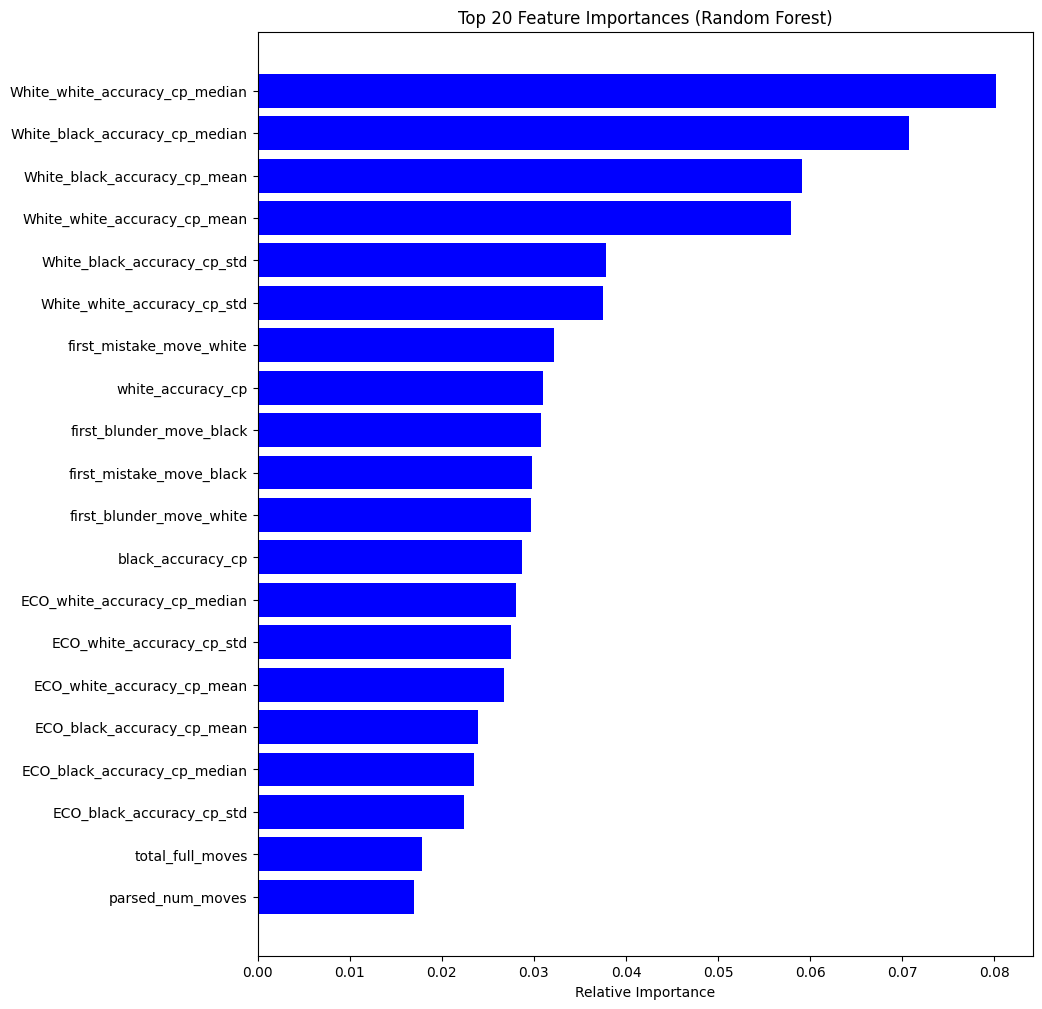

In [3]:
# Import the RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn import metrics

# Initialize the classifier with the specified hyperparameters for reproducibility
rfc = RandomForestClassifier(bootstrap=True, max_depth=16, min_samples_leaf=8, min_samples_split=6, n_estimators=1166, max_features='sqrt', random_state=42, n_jobs=-1)

# Train the model on the full feature set and the binned Elo target
rfc.fit(X_train, y_train_clf)

# Make predictions on the test data
y_pred_rfc = rfc.predict(X_test)

# Evaluate the model's performance
print("RandomForest Classification Accuracy:", metrics.accuracy_score(y_test_clf, y_pred_rfc))
print("Classification Report:", metrics.classification_report(y_test_clf, y_pred_rfc))

# --- Feature Importance Visualization ---
# Extract feature importances from the trained model
importances = rfc.feature_importances_
# Get the indices of the top 20 most important features
indices = np.argsort(importances)[-20:]

# Create a horizontal bar plot to visualize the feature importances
plt.figure(figsize=(10, 12))
plt.title('Top 20 Feature Importances (Random Forest)')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()